In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import math
from collections import Counter
from statistics import stdev
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import scipy.stats as stats
import statistics
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams['figure.figsize'] = 10, 8

In [2]:
#Preprocessing...
cols2 = ['age', 'educ', 'black', 'hisp', 'married', 'nodegr','re74','re75','re78']
lalonde_df=pd.read_csv('/content/drive/MyDrive/lalonde/lalonde.csv')
lalonde_df['re78'] = np.array(lalonde_df['re78']>0,dtype=float)
x_data=lalonde_df.iloc[:, 1:10]
y_data=lalonde_df.iloc[:, 0]
min_max_scaler = preprocessing.MinMaxScaler()
x_data = pd.DataFrame(min_max_scaler.fit_transform(x_data),columns=cols2)

In [3]:
#function to calculate ks test
def ks_w2(data1, data2, wei1, wei2):
    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)
    data1 = data1[ix1]
    data2 = data2[ix2]
    wei1 = wei1[ix1]
    wei2 = wei2[ix2]
    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(wei1) / sum(wei1)])
    cwei2 = np.hstack([0, np.cumsum(wei2) / sum(wei2)])
    cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
    cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]
    return np.max(np.abs(cdf1we - cdf2we))

In [4]:
#function to calculate ks test p-value
def ks_w2_p(data1, data2, wei1, wei2):
    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)
    data1 = data1[ix1]
    data2 = data2[ix2]
    wei1 = wei1[ix1]
    wei2 = wei2[ix2]
    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(wei1) / sum(wei1)])
    cwei2 = np.hstack([0, np.cumsum(wei2) / sum(wei2)])
    cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
    cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]
    a=stats.ttest_ind(a=cdf1we, b=cdf2we, equal_var=False)
    return a[1]

In [5]:
#function to estimate k-s test with p-vale percentage
data_probs=pd.DataFrame()

list_of_p_os = []
list_of_p_ipw = []
list_of_p_unw = []
for i in range(4):
  list_of_p_os.append([])
  list_of_p_ipw.append([])
  list_of_p_unw.append([])

feat=['age','educ','re74','re75']

def ks_cal(model_type):

  KS_weights=np.zeros(4)
  KS_ipw=np.zeros(4)
  KS_unw=np.zeros(4)
  for i in range(1,200):

      x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=i)
      #X_train_t=x_train.iloc[:, 2:30]
      X_train_t=x_train.iloc[:, 0:8]
      Y_train_t=y_train
      X_test_t=x_test.iloc[:, 0:8]
      Y_test_t=y_test
      if(model_type==0):
       model=SVC(probability=True,kernel='linear',C=100)
      elif(model_type==1):
       model = LogisticRegression()
      else:
        model=lgb.LGBMClassifier(max_depth=10)

      model.fit(X_train_t, Y_train_t)
      expected_y  = Y_test_t
      expected_yt  = Y_train_t
      predicted_y =model.predict(X_test_t)
      predicted_yt=model.predict(X_train_t)
      probs=model.predict_proba(X_test_t)
      data_probs['treat'] = y_test.values

      data_probs.loc[:,['P0','P1']] = probs
      data_probs['ipw']= np.where (data_probs['treat']==1, 1/data_probs['P1'], 1/data_probs['P0'])
      data_probs['e']= np.where (data_probs['treat']==1, 1-data_probs['P1'], 1-data_probs['P0'])
      #data_probs.loc[:, 'ep'] = np.power(data_probs.loc[:, 'e'],p)
      data_probs.loc[:, 'ep'] =(data_probs.loc[:, 'e'])

      weightsn = np.array(data_probs['ep'])
      invweightsn = np.array(data_probs['ipw'])
      x_test_n=x_test.copy()
      x_test_n['treat']=y_test.values
      data_treat=x_test_n[x_test_n['treat']==1]
      data_control=x_test_n[x_test_n['treat']==0]

      treat_weights=np.array(data_probs.loc[data_probs['treat']==1,'ep'])
      control_weights=np.array(data_probs.loc[data_probs['treat']==0,'ep'])
      treat_ipw=np.array(data_probs.loc[data_probs['treat']==1,'ipw'])
      control_ipw=np.array(data_probs.loc[data_probs['treat']==0,'ipw'])

      ind=0
      for k in feat:
        KS_weights[ind]=KS_weights[ind]+ks_w2(np.array(data_treat[k]),np.array(data_control[k]),treat_weights,control_weights)
        list_of_p_os[ind].append(ks_w2_p(np.array(data_treat[k]),np.array(data_control[k]),treat_weights,control_weights))
        KS_ipw[ind]=KS_ipw[ind]+ks_w2(np.array(data_treat[k]),np.array(data_control[k]),treat_ipw,control_ipw)
        list_of_p_ipw[ind].append(ks_w2_p(np.array(data_treat[k]),np.array(data_control[k]),treat_ipw,control_ipw))
        treat_ones=np.ones(len(np.array(data_treat[k])))
        control_ones=np.ones(len(np.array(data_control[k])))
        #res=ks_2samp(np.array(data_treat[x]),np.array(data_control[x]))
        #KS_unw[ind]= KS_unw[ind]+res[0]
        KS_unw[ind]= KS_unw[ind]+ks_w2(np.array(data_treat[k]),np.array(data_control[k]),treat_ones,control_ones)
        list_of_p_unw[ind].append(ks_w2_p(np.array(data_treat[k]),np.array(data_control[k]),treat_ones,control_ones))

        ind=ind+1
  KS_weights=(KS_weights/200)
  KS_ipw=(KS_ipw/200)
  KS_unw=(KS_unw/200)
  return KS_weights,KS_ipw,KS_unw

In [6]:
#0 =underfit, 1=moderate, 2=overfit
model_type=1
KS_weights,KS_ipw,KS_unw=ks_cal(model_type)
if(model_type==0):
  typeis='underfit'
elif(model_type==1):
  typeis='good'
else:
  typeis='overfit'

print('K-S weights OS',KS_weights)
print('sum of K-S weights OS',sum(KS_weights))
print ('Percentage of p-vale>0.05 for all features')
print ('-----------------------------------------')
for i in range(4):
  count = sum(map(lambda x : x>0.05, list_of_p_os[i]))
  #print(len(list_of_p_os))
  print(count/len(list_of_p_os[i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which w

K-S weights OS [0.31017382 0.19494882 0.29266812 0.22240975]
sum of K-S weights OS 1.0202004998069238
Percentage of p-vale>0.05 for all features
-----------------------------------------
0.5175879396984925
0.7638190954773869
0.09045226130653267
0.3065326633165829


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which w

In [7]:
def get_keys(val,dic):
    list=[]
    for key, value in dic.items():
        if val == value:
           list.append(key)
    return list

In [8]:
testdata_size = {}
for i in range(1000):
  x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=i)
  x_test_n=x_test.copy()
  x_test_n['treat']=y_test.values
  data_treat=x_test_n[x_test_n['treat']==1]
  data_control=x_test_n[x_test_n['treat']==0]
  testdata_size[i]=len(data_treat)
value, count = Counter(testdata_size.values()).most_common(1)[0]
list_of_seeds=get_keys(value,testdata_size)

In [9]:
X_Result_treat=[]
Y_Result_treat=[]
X_Result_control=[]
Y_Result_control=[]

def ecdf_cal(scheme):
  for i in list_of_seeds:
      x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=i)
      #X_train_t=x_train.iloc[:, 2:30]
      X_train_t=x_train.iloc[:, 0:8]
      Y_train_t=y_train
      X_test_t=x_test.iloc[:, 0:8]
      Y_test_t=y_test
      model = LogisticRegression()

      model.fit(X_train_t, Y_train_t)
      expected_y  = Y_test_t
      expected_yt  = Y_train_t
      predicted_y =model.predict(X_test_t)
      predicted_yt=model.predict(X_train_t)
      probs=model.predict_proba(X_test_t)
      data_probs['treat'] = y_test.values



      data_probs.loc[:,['P0','P1']] = probs
      data_probs['ipw']= np.where (data_probs['treat']==1, 1/data_probs['P1'], 1/data_probs['P0'])
      data_probs['e']= np.where (data_probs['treat']==1, 1-data_probs['P1'], 1-data_probs['P0'])
      #data_probs.loc[:, 'ep'] = np.power(data_probs.loc[:, 'e'],p)
      data_probs.loc[:, 'ep'] =(data_probs.loc[:, 'e'])

      weightsn = np.array(data_probs['ep'])
      invweightsn = np.array(data_probs['ipw'])
      x_test_n=x_test.copy()
      x_test_n['treat']=y_test.values
      data_treat=x_test_n[x_test_n['treat']==1]
      data_control=x_test_n[x_test_n['treat']==0]

      treat_weights=np.array(data_probs.loc[data_probs['treat']==1,'ep'])
      control_weights=np.array(data_probs.loc[data_probs['treat']==0,'ep'])
      treat_ipw=np.array(data_probs.loc[data_probs['treat']==1,'ipw'])
      control_ipw=np.array(data_probs.loc[data_probs['treat']==0,'ipw'])

      feature_treat_x=[]
      feature_treat_y=[]
      feature_control_x=[]
      feature_control_y=[]
      for x in feat:
        if(scheme==0):
          sns.ecdfplot(data=data_treat,y=x,weights=treat_weights )
          sns.ecdfplot(data=data_control,y=x,weights=control_weights)
        elif(scheme==1):
          sns.ecdfplot(data=data_treat,y=x,weights=treat_ipw )
          sns.ecdfplot(data=data_control,y=x,weights=control_ipw)
        else:
          sns.ecdfplot(data=data_treat,y=x)
          sns.ecdfplot(data=data_control,y=x)

        ax = plt.gca()
        treat = ax.lines[0]
        control=ax.lines[1]
        #x_data=treat.get_xdata()
        feature_treat_x.append(treat.get_xdata())
        feature_treat_y.append(treat.get_ydata())
        feature_control_x.append(control.get_xdata())
        feature_control_y.append(control.get_ydata())
        plt.close()
      X_Result_treat.append(feature_treat_x)
      Y_Result_treat.append(feature_treat_y)
      X_Result_control.append(feature_control_x)
      Y_Result_control.append(feature_control_y)


In [10]:
# OS=0, IPW=1, unweighted=2
scheme=0
ecdf_cal(scheme)
if(scheme==0):
  typeis='Our scheme'
elif(scheme==1):
  typeis='IPW'
else:
  typeis='Without weights'

#Avg of estimated ECDF
X_Result_treat_avg=[]
Y_Result_treat_avg=[]
X_Result_control_avg=[]
Y_Result_control_avg=[]

for i in range(0,4):
  column = i
  X_Result_treat_avg.append(sum(row[column] for row in X_Result_treat)/len(list_of_seeds))
  Y_Result_treat_avg.append(sum(row[column] for row in Y_Result_treat)/len(list_of_seeds))
  X_Result_control_avg.append(sum(row[column] for row in X_Result_control)/len(list_of_seeds))
  Y_Result_control_avg.append(sum(row[column] for row in Y_Result_control)/len(list_of_seeds))

Text(0.5, 1.0, 'ECDF weighted (Our scheme) on age ')

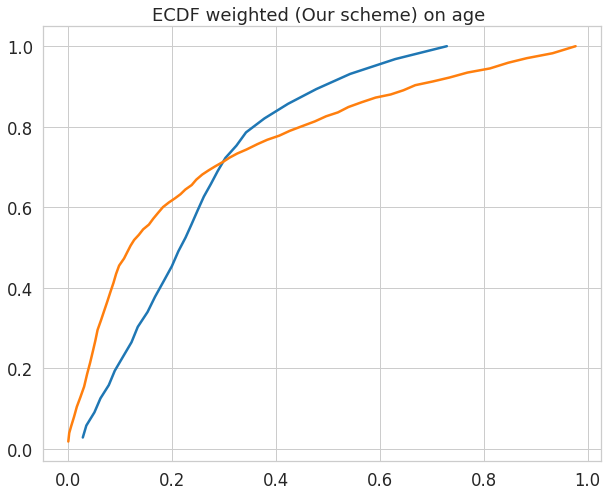

In [11]:
#plot of avg estimated ECDF
plt.plot(Y_Result_treat_avg[0],X_Result_treat_avg[0])
plt.plot(Y_Result_control_avg[0],X_Result_control_avg[0])
plt.title('ECDF weighted ('+typeis +') on age ')

Text(0.5, 1.0, 'ECDF weighted (Our scheme) on educ ')

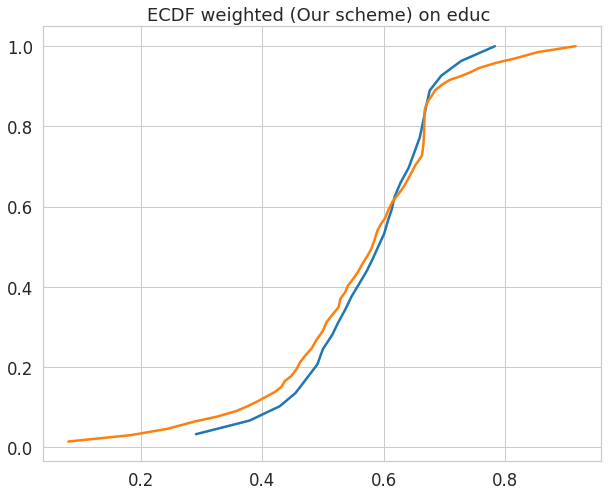

In [12]:
plt.plot(Y_Result_treat_avg[1],X_Result_treat_avg[1])
plt.plot(Y_Result_control_avg[1],X_Result_control_avg[1])
plt.title('ECDF weighted ('+typeis +') on educ ')

Text(0.5, 1.0, 'ECDF weighted (Our scheme) on re74')

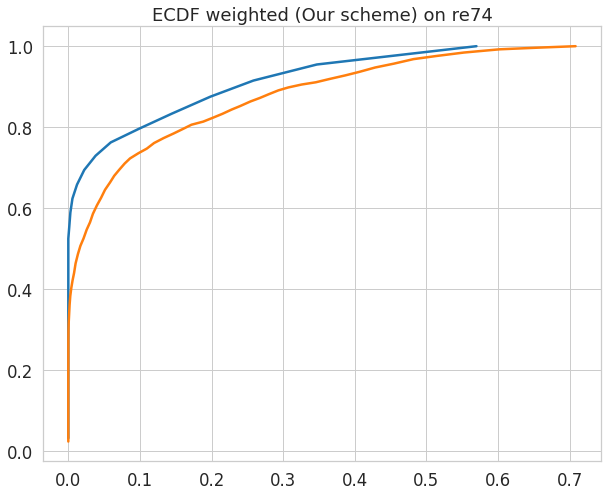

In [13]:
plt.plot(Y_Result_treat_avg[2],X_Result_treat_avg[2])
plt.plot(Y_Result_control_avg[2],X_Result_control_avg[2])
plt.title('ECDF weighted ('+typeis +') on re74')

Text(0.5, 1.0, 'ECDF weighted (Our scheme) on re75 ')

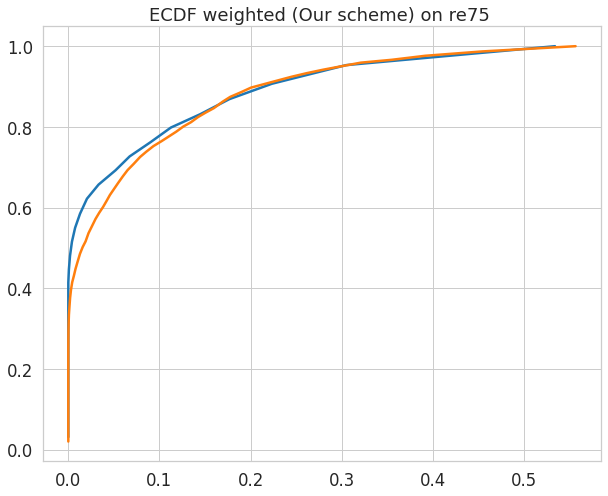

In [14]:
plt.plot(Y_Result_treat_avg[3],X_Result_treat_avg[3])
plt.plot(Y_Result_control_avg[3],X_Result_control_avg[3])
plt.title('ECDF weighted ('+typeis +') on re75 ')